In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import glob, os
import torch
import numpy as np

import seaborn as sns
import config_matplotlib
config_matplotlib.config_matplotlib()


registered cmap: seaborn_cubehelix



In [2]:
summary_yaml = '/pscratch/sd/z/zhantao/inxs_steering_production/benchmarks/summary.yaml'
import yaml

with open(summary_yaml, 'r') as file:
    summary_dict = yaml.safe_load(file)


In [3]:
steps_of_interest = [25, 50]

In [16]:
mean_preds = []
true_values = []
sample_ids = []
maes = []


measured_angles = []
method = 'poisson_unscaled_sf_50'

for path in summary_dict['real'][method]:
    pt_flist = glob.glob(os.path.join(summary_dict['path'], path, '*.pt'))
    pt_indices = sorted([int(_.split('/')[-1].split('.')[0]) for _ in pt_flist])

    for _idx, _idx in enumerate(pt_indices):
        _pt = torch.load(os.path.join(summary_dict['path'], path, f'{_idx:02d}.pt'))
        # print(_pt.keys())
        _mean_preds = (_pt['positions'] * _pt['weights'].unsqueeze(-1)).sum(dim=-2) / _pt['weights'].sum(dim=-1).unsqueeze(-1)
        
        # _mean_preds = _pt['means']
        
        # _maes = (_mean_preds - _pt['true_params'][None]).norm(dim=-1)
        # maes.append(_maes[steps_of_interest].unsqueeze(0))
        _maes = (_mean_preds - _pt['true_params'][None])[-1,None].abs()
        
        maes.append(_maes)
        mean_preds.append(_mean_preds.unsqueeze(0))
        sample_ids.append(_idx)
        true_values.append(_pt['true_params'])
        measured_angles.append(_pt['measured_angles'].unsqueeze(0))
        
maes = torch.vstack(maes).numpy()
mean_preds = torch.vstack(mean_preds).numpy()
sample_ids = torch.tensor(sample_ids).numpy()
true_values = torch.vstack(true_values).numpy()
measured_angles = torch.vstack(measured_angles).numpy()

Text(6.472222222222223, 0.5, 'Mean Absolute Error (MAE)')

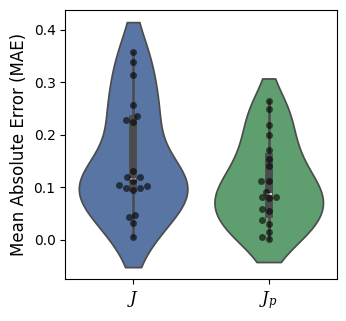

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(3.5, 3.5))
sns.violinplot(data=maes, ax=ax, cut=True)
sns.swarmplot(data=maes, ax=ax, color='black', alpha=0.6)
ax.set_xticks([0, 1])
ax.set_xticklabels(['$J$', '$J_{p}$'], fontsize=12)
ax.set_ylabel('Mean Absolute Error (MAE)')

In [6]:
# N_samp = mean_preds_demo.shape[1]

# N_samp_interp = 100

# step = 20

# markers = ['o', '^', 's', 'd']
# fig, ax = plt.subplots(1,1,figsize=(3.5,3.5))

# for _idx in range(1):
#     ax.plot(mean_preds[_idx,:,0], mean_preds[_idx,:,1], color=f'C0', alpha=0.5, zorder=1)

# ax.scatter(true_values[_idx,0], true_values[_idx,1], color=f'C2', zorder=10, s=50)
        
# ax.set_xlabel('$J$', fontdict={'size': 14})
# ax.set_ylabel('$J_{p}$', fontdict={'size': 14})
# # ax.set_xlim(20, 40)
# # ax.set_ylim(-5, 5)
# # ax.legend(fontsize=12)

In [7]:
import sys
sys.path.append('../')

from inxss import SpecNeuralRepr
from inxss.steer_neutron import NeutronExperimentSteerer

In [8]:
import hydra
from hydra import initialize, compose
from hydra.core.global_hydra import GlobalHydra

GlobalHydra.instance().clear()

with initialize(config_path="../conf"):
    cfg = compose(config_name="config_gaussian")
    
model_path = cfg['paths']['model_path']
data = torch.load(cfg['paths']['data_path'])

device = 'cuda' if torch.cuda.is_available() else 'cpu'

/tmp/ipykernel_1867505/2448110181.py:7: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path="../conf"):


In [9]:
particle_filter_config = {
    "num_particles": 1000,
    "dim_particles": 2,
    "prior_configs": {'types': ['uniform', 'uniform'], 'args': [{'low': 20, 'high': 40}, {'low': -5, 'high': 5}]}
}


grid_info = {
    k: [v.min().item(), v.max().item(), len(v)] for k,v in data['grid'].items()
}

mask_config = {
    "raw_mask_path": cfg['paths']['raw_mask_path'],
    "memmap_mask_path": cfg['paths']['memmap_mask_path'],
    "grid_info": grid_info,
    "preload": False,
    "build_from_scratch_if_no_memmap": True,
    "global_mask": data['S']>0
}

experiment_config = {
    "q_grid": tuple([data['grid'][_grid] for _grid in ['h_grid', 'k_grid', 'l_grid']]),
    "w_grid": data['grid']['w_grid'],
    "S_grid": data['S'],
    "S_scale_factor": 1.
}

background_config = {
    "q_grid": tuple([data['grid'][_grid] for _grid in ['h_grid', 'k_grid', 'l_grid']]),
    "w_grid": data['grid']['w_grid'],
    "bkg_grid": data['background']
}

model = SpecNeuralRepr.load_from_checkpoint(model_path).to(device)

steer = NeutronExperimentSteerer(
    model, particle_filter_config=particle_filter_config,
    mask_config=mask_config, experiment_config=experiment_config, background_config=background_config,
    tqdm_pbar=False, lkhd_dict=cfg['likelihood'], device='cuda')

obtained memmap mask name as: mask_h_-2.0_2.0_121_k_-2.0_2.0_121_l_-10.0_4.5_30_w_20.0_200.0_91.npy


In [10]:
from inxss import linspace_2D_equidistant, plot_points, get_Sqw_func

# _, kpt_indices = linspace_2D_equidistant([[0,0],[0.5,0],[0.5,0.5],[0,0]], 100, return_indices=True)
# kpts = torch.from_numpy(linspace_2D_equidistant([[0,0],[0.5,0],[0.5,0.5],[0,0]], 100))
_, kpt_indices = linspace_2D_equidistant([[1/4,1/4], [1/2,1/2], [0,1/2], [1/4,1/4], [0,0], [0,1/2]], 100, return_indices=True)
kpts = torch.from_numpy(linspace_2D_equidistant([[1/4,1/4],[1/2,1/2],[0,1/2],[1/4,1/4], [0,0], [0,1/2]], 100))
wpts = steer.experiment.w_grid
qw_coords = []
for _l in steer.experiment.l_grid:
    _qw_coords = torch.cat([
        kpts.unsqueeze(0).expand(wpts.shape[0], -1, -1),
        _l * torch.ones(wpts.shape[0], kpts.shape[0], 1),
        wpts.view(wpts.shape[0], -1).unsqueeze(1).expand(-1, kpts.shape[0], -1)
       ], dim=2)
    qw_coords.append(_qw_coords)
    
kpt_labels = ['$\mathrm{P}$', '$\mathrm{M}$', '$\mathrm{X}$', '$\mathrm{P}$', '$\Gamma$', '$\mathrm{X}$']
# kpt_labels = ['K'] * len(kpt_indices)

In [11]:
S_exp = 0.
for _qw_coords in qw_coords:
    S_exp += steer.experiment.get_measurements_on_coords(_qw_coords)

In [12]:
cmap = sns.color_palette("rocket", as_cmap=True)

config_matplotlib.config_matplotlib()


registered cmap: seaborn_cubehelix



/global/u2/z/zhantao/Projects/inxs_steering/paper_preperation/config_matplotlib.py:44: UserWarning: Trying to register the cmap 'seaborn_cubehelix' which already exists.
  plt.register_cmap(cmap=cmap)


tensor([30.3879, -0.1770], device='cuda:0', dtype=torch.float64)
tensor([27.6731,  0.2949], device='cuda:0', dtype=torch.float64)
tensor([29.1398,  1.7294], device='cuda:0', dtype=torch.float64)


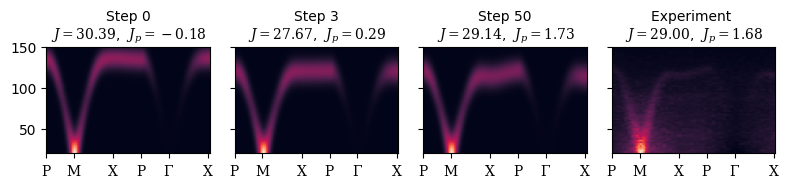

In [13]:
_idx_demo_detail = 16
params_list = []
S_pred_list = []

steps_demo = [0, 3, 50]

for params in mean_preds[_idx_demo_detail,steps_demo,:]:
    params = torch.from_numpy(params).to(device)
    print(params)
    x = torch.zeros(wpts.shape[0], kpts.shape[0], 5)
    x[...,:3] = torch.cat([
        kpts.unsqueeze(0).expand(wpts.shape[0], -1, -1),
        wpts.view(wpts.shape[0], -1).unsqueeze(1).expand(-1, kpts.shape[0], -1)
    ], dim=2)
    x[...,3:] = params

    S_pred = model(x.to(model.device)).reshape(wpts.shape[0], kpts.shape[0]).detach().cpu().numpy()
    
    params_list.append(params)
    S_pred_list.append(S_pred)
    
w_idx_upper = 65
aspect = 0.5
extent = [0, S_pred_list[0].shape[1], 
          steer.experiment.w_grid.min().item(), steer.experiment.w_grid[w_idx_upper].item()]

fig, ax = plt.subplots(1, 4, figsize=(8, 6))
for i in range(3):
    ax[i].imshow(S_pred_list[i][:w_idx_upper,:], origin='lower', cmap=cmap, extent=extent, aspect=aspect)
    ax[i].set_title(f'Step {steps_demo[i]}\n $J={params_list[i][0]:.2f}$,  $J_{{p}}={params_list[i][1]:.2f}$',
                    fontsize=10)
ax[3].imshow(S_exp[:w_idx_upper,:], origin='lower', cmap=cmap, extent=extent, aspect=aspect)
ax[3].set_title('Experiment \n $J=29.00$,  $J_{{p}}=1.68$',
                fontsize=10)

for i_ax, _ax in enumerate(ax):
    _ax.set_xticks(kpt_indices)
    _ax.set_xticklabels(kpt_labels)
    if i_ax > 0:
        _ax.set_yticklabels([])

# fig.suptitle(rf'$J={params[0]:.2f}, \ J_{{p}}={params[1]:.2f}$')
fig.tight_layout()
# fig.savefig(f"test_idx_{idx_plot}.svg", bbox_inches='tight')

/tmp/ipykernel_1867505/18776110.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


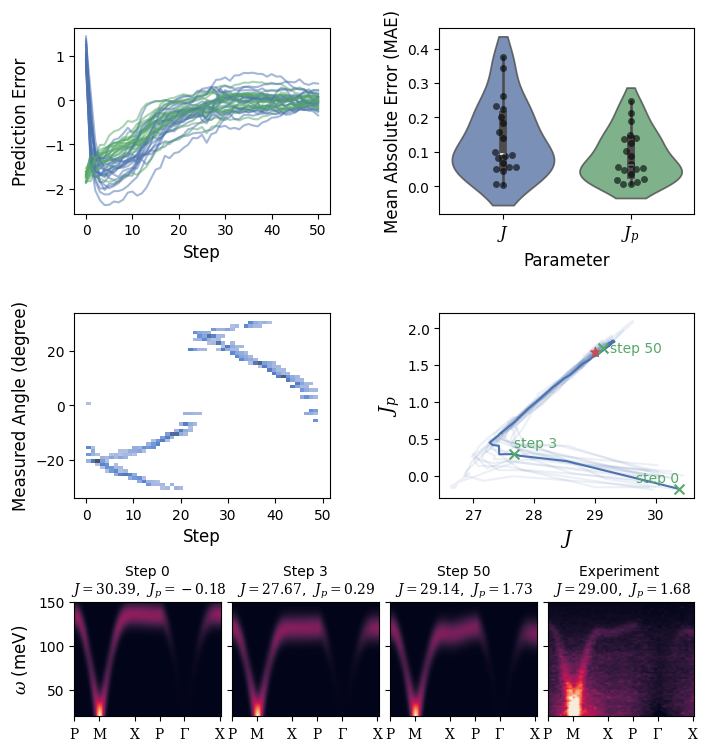

In [14]:

measured_angles[measured_angles > 180] -= 360


fig = plt.figure(figsize=(8,9))

gs = fig.add_gridspec(3, 4, height_ratios=[3,3,2], wspace=1.5, hspace=0.6)


ax_mae_hist = fig.add_subplot(gs[0, 2:])
ax_traj = fig.add_subplot(gs[1, 2:])
ax_ang = fig.add_subplot(gs[1, :2])
ax_mae_step = fig.add_subplot(gs[0, :2])

sns.violinplot(data=maes, ax=ax_mae_hist, cut=True, alpha=0.8)
sns.swarmplot(data=maes, ax=ax_mae_hist, color='black', alpha=0.6)
ax_mae_hist.set_xticks([0, 1])
ax_mae_hist.set_xticklabels(['$J$', '$J_{p}$'], fontsize=12)
ax_mae_hist.set_ylabel('Mean Absolute Error (MAE)')
ax_mae_hist.set_xlabel('Parameter')


for _idx in range(mean_preds.shape[0]):
    if _idx == _idx_demo_detail:
        ax_traj.plot(mean_preds[_idx,:,0], mean_preds[_idx,:,1], color=f'C0', zorder=1)
    else:
        ax_traj.plot(mean_preds[_idx,:,0], mean_preds[_idx,:,1], color=f'C0', alpha=0.1, zorder=1)


ax_traj.scatter(true_values[_idx_demo_detail,0], true_values[_idx_demo_detail,1], marker='*', color=f'C2', zorder=10, s=50)     
ax_traj.scatter(mean_preds[_idx_demo_detail,steps_demo,0], mean_preds[_idx_demo_detail,steps_demo,1], marker='x', color='C1', zorder=10, s=50)
ax_traj.text(mean_preds[_idx_demo_detail,steps_demo[0],0], mean_preds[_idx_demo_detail,steps_demo[0],1]+0.05, 
         f'step {steps_demo[0]}', fontsize=10, ha='right', va='bottom', color='C1')
ax_traj.text(mean_preds[_idx_demo_detail,steps_demo[1],0], mean_preds[_idx_demo_detail,steps_demo[1],1]+0.05, 
         f'step {steps_demo[1]}', fontsize=10, ha='left', va='bottom', color='C1')
ax_traj.text(mean_preds[_idx_demo_detail,steps_demo[2],0]+0.1, mean_preds[_idx_demo_detail,steps_demo[2],1], 
         f'step {steps_demo[2]}', fontsize=10, ha='left', va='center', color='C1')
ax_traj.set_xlabel('$J$', fontdict={'size': 14})
ax_traj.set_ylabel('$J_{p}$', fontdict={'size': 14})
# ax_traj.yaxis.tick_right()  # Move yticks to the right
# ax_traj.yaxis.set_label_position("right")  # Move ylabels to the right

# for i in range(measured_angles.shape[1]):
#     ax_ang.plot(i * np.ones_like(measured_angles[:,i]), measured_angles[:,i], 'o', color=cmap(i/50), markersize=2.5);
sns.histplot(x=np.repeat(np.arange(50)[None,:], 20, axis=0).reshape(-1), y=measured_angles.reshape(-1), bins=50, ax=ax_ang)
ax_ang.set_xlabel('Step')
ax_ang.set_ylabel('Measured Angle (degree)')


mae_hist = (mean_preds - true_values[:,None,:])
for i in range(mae_hist.shape[0]):
    ax_mae_step.plot(np.arange(mae_hist.shape[1]), mae_hist[i,:,0], alpha=0.5, color='C0')
    ax_mae_step.plot(np.arange(mae_hist.shape[1]), mae_hist[i,:,1], alpha=0.5, color='C1')
ax_mae_step.set_xlabel('Step')
ax_mae_step.set_ylabel('Prediction Error')

cmap = sns.color_palette("rocket", as_cmap=True)
sub_gs = gs[-1,:].subgridspec(1, 4, wspace=0.075)

aspect = .6
axes_to_align1 = []
for i in range(3):
    _ax = fig.add_subplot(sub_gs[0, i])
    _ax.imshow(S_pred_list[i][:w_idx_upper,:], origin='lower', cmap=cmap, extent=extent, aspect=aspect)
    _ax.set_title(f'Step {steps_demo[i]}\n $J={params_list[i][0]:.2f}$,  $J_{{p}}={params_list[i][1]:.2f}$',
                    fontsize=10)
    _ax.set_xticks(kpt_indices)
    _ax.set_xticklabels(kpt_labels)
    if i >0:
        _ax.set_yticklabels([])
    else:
        _ax.set_ylabel('$\omega$ (meV)')
        axes_to_align1.append(_ax)

ax = fig.add_subplot(sub_gs[-1, -1])
ax.imshow(S_exp[:w_idx_upper,:], origin='lower', cmap=cmap, extent=extent, aspect=aspect, vmax=S_exp.max() * 0.5)
ax.set_title('Experiment \n $J=29.00$,  $J_{{p}}=1.68$',
                fontsize=10)
ax.set_yticklabels([])
ax.set_xticks(kpt_indices)
ax.set_xticklabels(kpt_labels)

fig.align_ylabels([ax_mae_step, ax_ang, ] + axes_to_align1)
fig.align_ylabels([ax_mae_hist, ax_traj])

fig.tight_layout()
fig.savefig('figures/exp_benchmark_summary.pdf', bbox_inches='tight')

In [15]:
results_shifted_init = {}

for _method_suffix in ['center', 'lowerleft', 'lowerright', 'upperleft', 'upperright']:
    
    mean_preds_si = []
    true_values_si = []
    sample_ids_si = []
    maes_si = []
    measured_angles_si = []
    
    if _method_suffix == 'center':
        method = 'poisson_scaled'
    else:
        method = 'poisson_scaled_shifted_init_' + _method_suffix

    for path in summary_dict['real'][method]:
        pt_flist = glob.glob(os.path.join(summary_dict['path'], path, '*.pt'))
        pt_indices = sorted([int(_.split('/')[-1].split('.')[0]) for _ in pt_flist])

        for _idx, _idx in enumerate(pt_indices):
            _pt = torch.load(os.path.join(summary_dict['path'], path, f'{_idx:02d}.pt'))
            # print(_pt.keys())
            _mean_preds = (_pt['positions'] * _pt['weights'].unsqueeze(-1)).sum(dim=-2) / _pt['weights'].sum(dim=-1).unsqueeze(-1)
            
            # _mean_preds = _pt['means']
            
            # _maes = (_mean_preds - _pt['true_params'][None]).norm(dim=-1)
            # maes.append(_maes[steps_of_interest].unsqueeze(0))
            _maes = (_mean_preds - _pt['true_params'][None])[-1,None].abs()
            
            maes_si.append(_maes)
            mean_preds_si.append(_mean_preds.unsqueeze(0))
            sample_ids_si.append(_idx)
            true_values_si.append(_pt['true_params'])
            measured_angles_si.append(_pt['measured_angles'].unsqueeze(0))
        
    maes_si = torch.vstack(maes_si).numpy()
    mean_preds_si = torch.vstack(mean_preds_si).numpy()
    sample_ids_si = torch.tensor(sample_ids_si).numpy()
    true_values_si = torch.vstack(true_values_si).numpy()
    measured_angles_si = torch.vstack(measured_angles_si).numpy()
    
    results_shifted_init[_method_suffix] = {
        'maes': maes_si,
        'mean_preds': mean_preds_si,
        'true_values': true_values_si,
        'sample_ids': sample_ids_si,
        'measured_angles': measured_angles_si
    }

Fit slope = [0.69770149]
fit slope and intercept: [ 0.69660407 -0.01420433]


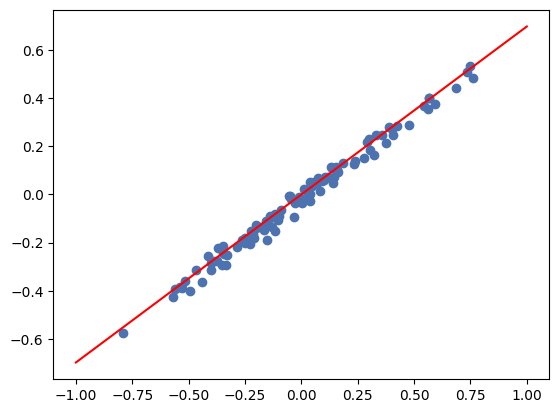

In [16]:
all_pred_error = []

for _method_suffix in ['lowerleft', 'lowerright', 'center', 'upperleft', 'upperright']:

    pred_error = results_shifted_init[_method_suffix]['mean_preds'] - results_shifted_init[_method_suffix]['true_values'][:,None,:]
    all_pred_error.append(pred_error[:,-1,:])
all_pred_error = np.vstack(all_pred_error)
 
from scipy.optimize import curve_fit

def fit_func(x, a):
    # Curve fitting function
    return a * x

fit_params = curve_fit(fit_func, all_pred_error[:,0], all_pred_error[:,1])
# Print the fit parameters
print("Fit slope =", fit_params[0])

# Perform linear fit
fit_col = np.polyfit(all_pred_error[:,0], all_pred_error[:,1], 1)
print('fit slope and intercept:', fit_col)

plt.scatter(*all_pred_error.T)
plt.plot(np.linspace(-1, 1, 101), fit_params[0] * np.linspace(-1, 1, 101), color='red')

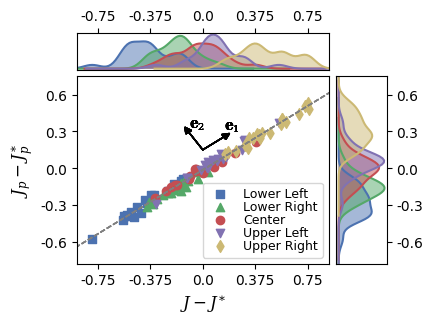

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

fig, axes = plt.subplots(2, 2, 
                         figsize=(4, 3), 
                         gridspec_kw={
                             'width_ratios': [1, 0.2], 
                             'height_ratios': [0.2, 1], 
                             'hspace': 0.05, 
                             'wspace': 0.05})
ax = axes[1,0]
ax1 = axes[0,0]
ax2 = axes[1,1]

axes[0,1].axis('off')

legend_dict = {
    'center': 'Center',
    'lowerleft': 'Lower Left',
    'lowerright': 'Lower Right',
    'upperleft': 'Upper Left',
    'upperright': 'Upper Right'
}
# legend_dict = {
#     'center': r'$[20,40] \times [-5,5]$',
#     'lowerleft': r'$[20,32] \times [-5,2]$',
#     'lowerright': r'$[28,40] \times [-5,2]$',
#     'upperleft': r'$[20,32] \times [-2,5]$',
#     'upperright': r'$[28,40] \times [-2,5]$'
# }
marker_dict = {
    'center': 'o',
    'lowerleft': 's',
    'lowerright': '^',
    'upperleft': 'v',
    'upperright': 'd'
}

for _method_suffix in ['lowerleft', 'lowerright', 'center', 'upperleft', 'upperright']:

    pred_error = results_shifted_init[_method_suffix]['mean_preds'] - results_shifted_init[_method_suffix]['true_values'][:,None,:]

    # plt.scatter(pred_error[:,-1,0], pred_error[:,-1,1])
    # Scatter plot in the middle
    ax.scatter(pred_error[:,-1,0], pred_error[:,-1,1], label=legend_dict[_method_suffix], marker=marker_dict[_method_suffix])
    (xmin, xmax) = ax.get_xlim()
    ax.plot(np.linspace(-1, 1, 101), np.polyval(fit_col, np.linspace(-1, 1, 101)), color='gray', linewidth=1, linestyle='--')
    ax.set_xlim(-0.9, 0.9) 
    ax.legend(loc='lower right', ncol=1, fontsize=9, labelspacing=0.0)
    ax.set_xticks(np.linspace(-0.75, 0.75, 5))
    ax.set_xticklabels(np.round(np.linspace(-0.75, 0.75, 5), decimals=3))
    ax.set_yticks(np.linspace(-0.6, 0.6, 5))
    ax.set_yticklabels(np.round(np.linspace(-0.6, 0.6, 5), decimals=3))
    ax.set_xlabel(r'$J-J^{\ast}$')
    ax.set_ylabel(r'$J_{p}-J_{p}^{\ast}$')

    X_plot = np.linspace(pred_error[:,-1,0].min()-0.5, pred_error[:,-1,0].max()+0.5, 100)[:, np.newaxis]
    kde = KernelDensity(kernel="gaussian", bandwidth=0.06).fit(pred_error[:,-1,0].reshape(-1,1))
    log_dens = kde.score_samples(X_plot)
    ax1.plot(X_plot[:, 0], np.exp(log_dens))
    ax1.fill_between(X_plot[:,0], np.exp(log_dens), alpha=0.5)
    ax1.xaxis.set_label_position("top")
    ax1.xaxis.tick_top()
    ax1.set_xticks(np.linspace(-0.75, 0.75, 5))
    ax1.set_xticklabels(np.round(np.linspace(-0.75, 0.75, 5), decimals=3))
    ax1.set_yticks([])
    
    Y_plot = np.linspace(pred_error[:,-1,1].min()-0.5, pred_error[:,-1,1].max()+0.5, 100)[:, np.newaxis]
    kde = KernelDensity(kernel="gaussian", bandwidth=0.06).fit(pred_error[:,-1,1].reshape(-1,1))
    log_dens = kde.score_samples(Y_plot)
    ax2.plot(np.exp(log_dens), Y_plot[:, 0])
    ax2.fill_betweenx(Y_plot[:,0], np.exp(log_dens), alpha=0.5)
    ax2.yaxis.set_label_position("right")
    ax2.yaxis.tick_right()
    ax2.set_yticks(np.linspace(-0.6, 0.6, 5))
    ax2.set_yticklabels(np.round(np.linspace(-0.6, 0.6, 5), decimals=3))
    ax2.set_xticks([])
    
    # ax.set_aspect('equal')
        
    ax1.set_xlim(ax.get_xlim())
    ax2.set_ylim(ax.yaxis.get_view_interval())
    
    ax.arrow(0, 0.15, 0.15, 0.15 * fit_col[0], 
             head_width=0.05, head_length=0.05, fc='k', ec='k')
    ax.text(0.15, 0.175 + 0.15 * fit_col[0], '$\mathbf{e}_{1}$', 
            fontsize=10, va='bottom', ha='left')
    ax.arrow(0, 0.15, -0.1, 0.1 * 1 / fit_col[0], 
             head_width=0.05, head_length=0.05, fc='k', ec='k')
    ax.text(-0.1, 0.15 + 0.1 * 1 / fit_col[0], '$\mathbf{e}_{2}$', 
            fontsize=10, va='bottom', ha='left')
fig.savefig('figures/exp_benchmark_summary_shifted_init.pdf', bbox_inches='tight')

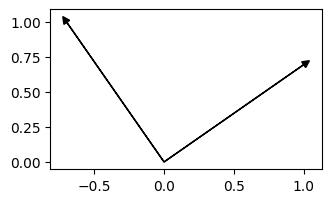

In [18]:
a = fit_col[0]

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3.5))
ax.arrow(0, 0, 1, a, head_width=0.05, head_length=0.05, fc='k', ec='k')
ax.arrow(0, 0, -a, 1, head_width=0.05, head_length=0.05, fc='k', ec='k')

ax.set_aspect('equal')


/tmp/ipykernel_1867505/2520707569.py:90: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


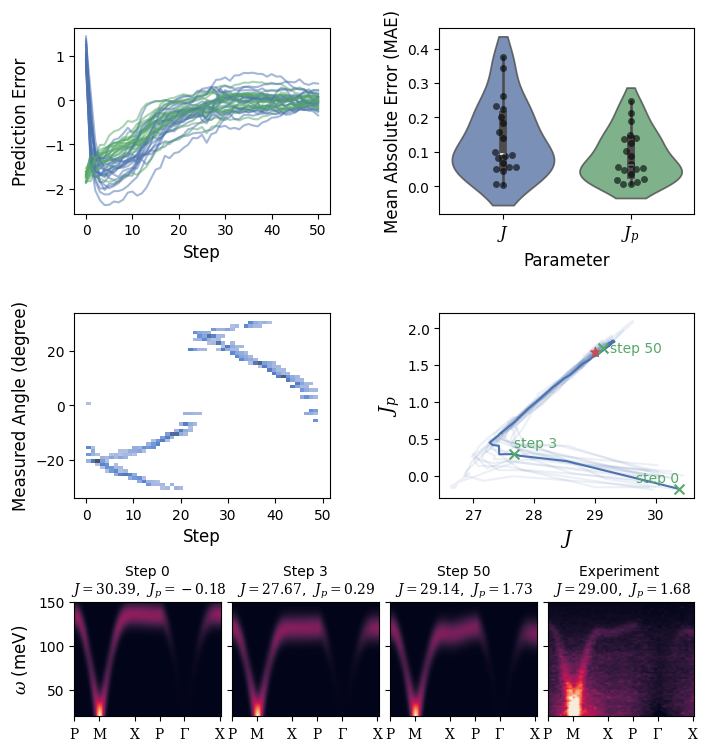

In [19]:
shift_type = 'center'
maes_demo = results_shifted_init[shift_type]['maes']
true_values_demo = results_shifted_init[shift_type]['true_values']
mean_preds_demo = results_shifted_init[shift_type]['mean_preds']

measured_angles_demo = results_shifted_init[shift_type]['measured_angles']
measured_angles_demo[measured_angles_demo > 180] -= 360

fig = plt.figure(figsize=(8,9))

gs = fig.add_gridspec(3, 4, height_ratios=[3,3,2], wspace=1.5, hspace=0.6)


ax_mae_hist = fig.add_subplot(gs[0, 2:])
ax_traj = fig.add_subplot(gs[1, 2:])
ax_ang = fig.add_subplot(gs[1, :2])
ax_mae_step = fig.add_subplot(gs[0, :2])

sns.violinplot(data=maes_demo, ax=ax_mae_hist, cut=True, alpha=0.8)
sns.swarmplot(data=maes_demo, ax=ax_mae_hist, color='black', alpha=0.6)
ax_mae_hist.set_xticks([0, 1])
ax_mae_hist.set_xticklabels(['$J$', '$J_{p}$'], fontsize=12)
ax_mae_hist.set_ylabel('Mean Absolute Error (MAE)')
ax_mae_hist.set_xlabel('Parameter')


for _idx in range(mean_preds_demo.shape[0]):
    if _idx == _idx_demo_detail:
        ax_traj.plot(mean_preds_demo[_idx,:,0], mean_preds_demo[_idx,:,1], color=f'C0', zorder=1)
    else:
        ax_traj.plot(mean_preds_demo[_idx,:,0], mean_preds_demo[_idx,:,1], color=f'C0', alpha=0.1, zorder=1)


ax_traj.scatter(true_values_demo[_idx_demo_detail,0], true_values_demo[_idx_demo_detail,1], marker='*', color=f'C2', zorder=10, s=50)     
ax_traj.scatter(mean_preds_demo[_idx_demo_detail,steps_demo,0], mean_preds_demo[_idx_demo_detail,steps_demo,1], marker='x', color='C1', zorder=10, s=50)
ax_traj.text(mean_preds_demo[_idx_demo_detail,steps_demo[0],0], mean_preds_demo[_idx_demo_detail,steps_demo[0],1]+0.05, 
         f'step {steps_demo[0]}', fontsize=10, ha='right', va='bottom', color='C1')
ax_traj.text(mean_preds_demo[_idx_demo_detail,steps_demo[1],0], mean_preds_demo[_idx_demo_detail,steps_demo[1],1]+0.05, 
         f'step {steps_demo[1]}', fontsize=10, ha='left', va='bottom', color='C1')
ax_traj.text(mean_preds_demo[_idx_demo_detail,steps_demo[2],0]+0.1, mean_preds_demo[_idx_demo_detail,steps_demo[2],1], 
         f'step {steps_demo[2]}', fontsize=10, ha='left', va='center', color='C1')
ax_traj.set_xlabel('$J$', fontdict={'size': 14})
ax_traj.set_ylabel('$J_{p}$', fontdict={'size': 14})
# ax_traj.yaxis.tick_right()  # Move yticks to the right
# ax_traj.yaxis.set_label_position("right")  # Move ylabels to the right

# for i in range(measured_angles.shape[1]):
#     ax_ang.plot(i * np.ones_like(measured_angles[:,i]), measured_angles[:,i], 'o', color=cmap(i/50), markersize=2.5);
sns.histplot(x=np.repeat(np.arange(50)[None,:], 20, axis=0).reshape(-1), y=measured_angles_demo.reshape(-1), bins=50, ax=ax_ang)
ax_ang.set_xlabel('Step')
ax_ang.set_ylabel('Measured Angle (degree)')


mae_hist = (mean_preds_demo - true_values_demo[:,None,:])
for i in range(mae_hist.shape[0]):
    ax_mae_step.plot(np.arange(mae_hist.shape[1]), mae_hist[i,:,0], alpha=0.5, color='C0')
    ax_mae_step.plot(np.arange(mae_hist.shape[1]), mae_hist[i,:,1], alpha=0.5, color='C1')
ax_mae_step.set_xlabel('Step')
ax_mae_step.set_ylabel('Prediction Error')

cmap = sns.color_palette("rocket", as_cmap=True)
sub_gs = gs[-1,:].subgridspec(1, 4, wspace=0.075)

aspect = .6
axes_to_align1 = []
for i in range(3):
    _ax = fig.add_subplot(sub_gs[0, i])
    _ax.imshow(S_pred_list[i][:w_idx_upper,:], origin='lower', cmap=cmap, extent=extent, aspect=aspect)
    _ax.set_title(f'Step {steps_demo[i]}\n $J={params_list[i][0]:.2f}$,  $J_{{p}}={params_list[i][1]:.2f}$',
                    fontsize=10)
    _ax.set_xticks(kpt_indices)
    _ax.set_xticklabels(kpt_labels)
    if i >0:
        _ax.set_yticklabels([])
    else:
        _ax.set_ylabel('$\omega$ (meV)')
        axes_to_align1.append(_ax)

ax = fig.add_subplot(sub_gs[-1, -1])
ax.imshow(S_exp[:w_idx_upper,:], origin='lower', cmap=cmap, extent=extent, aspect=aspect, vmax=S_exp.max() * 0.5)
ax.set_title('Experiment \n $J=29.00$,  $J_{{p}}=1.68$',
                fontsize=10)
ax.set_yticklabels([])
ax.set_xticks(kpt_indices)
ax.set_xticklabels(kpt_labels)

fig.align_ylabels([ax_mae_step, ax_ang, ] + axes_to_align1)
fig.align_ylabels([ax_mae_hist, ax_traj])

fig.tight_layout()

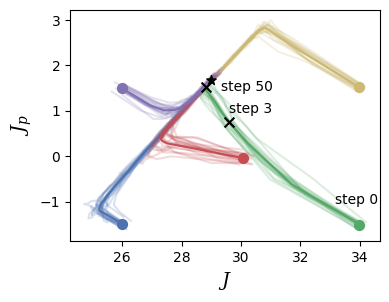

In [20]:
fig, ax_traj = plt.subplots(1, 1, figsize=(4, 3))

for i_suffix, _method_suffix in enumerate(['lowerleft', 'lowerright', 'center', 'upperleft', 'upperright']):
    mean_preds_demo = results_shifted_init[_method_suffix]['mean_preds']
    ax_traj.plot(mean_preds_demo.mean(axis=0)[:,0], mean_preds_demo.mean(axis=0)[:,1], color=f'C{i_suffix}', zorder=1)
    for _idx in range(mean_preds_demo.shape[0]):
        ax_traj.plot(mean_preds_demo[_idx,:,0], mean_preds_demo[_idx,:,1], color=f'C{i_suffix}', alpha=0.2, zorder=1)


    if _method_suffix == 'lowerright':
        ax_traj.scatter(true_values_demo[_idx_demo_detail,0], true_values_demo[_idx_demo_detail,1], marker='*', color=f'k', zorder=10, s=50)     
        ax_traj.scatter(mean_preds_demo.mean(axis=0)[0,0], mean_preds_demo.mean(axis=0)[0,1], marker='o', color=f'C{i_suffix}', zorder=10, s=50)
        ax_traj.scatter(mean_preds_demo.mean(axis=0)[steps_demo[1:],0], mean_preds_demo.mean(axis=0)[steps_demo[1:],1], marker='x', color='k', zorder=10, s=50)
        ax_traj.text(mean_preds_demo.mean(axis=0)[steps_demo[0],0]-0.1, mean_preds_demo.mean(axis=0)[steps_demo[0],1]+0.4, 
                f'step {steps_demo[0]}', fontsize=10, ha='center', va='bottom', color='k')
        ax_traj.text(mean_preds_demo.mean(axis=0)[steps_demo[1],0], mean_preds_demo.mean(axis=0)[steps_demo[1],1]+0.15, 
                f'step {steps_demo[1]}', fontsize=10, ha='left', va='bottom', color='k')
        ax_traj.text(mean_preds_demo.mean(axis=0)[steps_demo[2],0]+0.5, mean_preds_demo.mean(axis=0)[steps_demo[2],1], 
                f'step {steps_demo[2]}', fontsize=10, ha='left', va='center', color='k')
    else:
        ax_traj.scatter(mean_preds_demo.mean(axis=0)[0,0], mean_preds_demo.mean(axis=0)[0,1], marker='o', color=f'C{i_suffix}', zorder=10, s=50)
        
ax_traj.set_xlabel('$J$', fontdict={'size': 14})
ax_traj.set_ylabel('$J_{p}$', fontdict={'size': 14})
fig.savefig('figures/exp_benchmark_summary_shifted_init_traj.pdf', bbox_inches='tight')

In [21]:
# fig, ax_traj = plt.subplots(1, 1, figsize=(4, 3))

# for i_suffix, _method_suffix in enumerate(['lowerleft', 'lowerright', 'center', 'upperleft', 'upperright']):
#     mean_preds_demo = results_shifted_init[_method_suffix]['mean_preds']
#     for _idx in range(mean_preds_demo.shape[0]):
#         if _idx == _idx_demo_detail:
#             ax_traj.plot(mean_preds_demo[_idx,:,0], mean_preds_demo[_idx,:,1], color=f'C{i_suffix}', zorder=1)
#         else:
#             ax_traj.plot(mean_preds_demo[_idx,:,0], mean_preds_demo[_idx,:,1], color=f'C{i_suffix}', alpha=0.1, zorder=1)


#     if _method_suffix == 'lowerright':
#         ax_traj.scatter(true_values_demo[_idx_demo_detail,0], true_values_demo[_idx_demo_detail,1], marker='*', color=f'k', zorder=10, s=50)     
#         ax_traj.scatter(mean_preds_demo[_idx_demo_detail,0,0], mean_preds_demo[_idx_demo_detail,0,1], marker='o', color=f'C{i_suffix}', zorder=10, s=50)
#         ax_traj.scatter(mean_preds_demo[_idx_demo_detail,steps_demo[1:],0], mean_preds_demo[_idx_demo_detail,steps_demo[1:],1], marker='x', color='k', zorder=10, s=50)
#         ax_traj.text(mean_preds_demo[_idx_demo_detail,steps_demo[0],0]+0.04, mean_preds_demo[_idx_demo_detail,steps_demo[0],1]+0.25, 
#                 f'step {steps_demo[0]}', fontsize=10, ha='center', va='bottom', color='k')
#         ax_traj.text(mean_preds_demo[_idx_demo_detail,steps_demo[1],0], mean_preds_demo[_idx_demo_detail,steps_demo[1],1]+0.15, 
#                 f'step {steps_demo[1]}', fontsize=10, ha='left', va='bottom', color='k')
#         ax_traj.text(mean_preds_demo[_idx_demo_detail,steps_demo[2],0]+0.5, mean_preds_demo[_idx_demo_detail,steps_demo[2],1], 
#                 f'step {steps_demo[2]}', fontsize=10, ha='left', va='center', color='k')
#     else:
#         ax_traj.scatter(mean_preds_demo[_idx_demo_detail,0,0], mean_preds_demo[_idx_demo_detail,0,1], marker='o', color=f'C{i_suffix}', zorder=10, s=50)
        
# ax_traj.set_xlabel('$J$', fontdict={'size': 14})
# ax_traj.set_ylabel('$J_{p}$', fontdict={'size': 14})
# fig.savefig('figures/exp_benchmark_summary_shifted_init_traj.pdf', bbox_inches='tight')

tensor([33.9918, -1.5065], device='cuda:0', dtype=torch.float64)
tensor([29.6068,  0.7469], device='cuda:0', dtype=torch.float64)
tensor([28.8241,  1.5231], device='cuda:0', dtype=torch.float64)


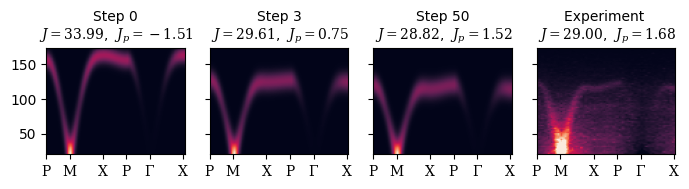

In [22]:
_idx_demo_detail = 16
params_list = []
S_pred_list = []

steps_demo = [0, 3, 50]

mean_preds_demo = results_shifted_init['lowerright']['mean_preds']

# for params in mean_preds_demo[_idx_demo_detail,steps_demo,:]:
for params in mean_preds_demo.mean(axis=0)[steps_demo,:]:
    params = torch.from_numpy(params).to(device)
    print(params)
    x = torch.zeros(wpts.shape[0], kpts.shape[0], 5)
    x[...,:3] = torch.cat([
        kpts.unsqueeze(0).expand(wpts.shape[0], -1, -1),
        wpts.view(wpts.shape[0], -1).unsqueeze(1).expand(-1, kpts.shape[0], -1)
    ], dim=2)
    x[...,3:] = params

    S_pred = model(x.to(model.device)).reshape(wpts.shape[0], kpts.shape[0]).detach().cpu().numpy()
    
    params_list.append(params)
    S_pred_list.append(S_pred)
    
w_idx_upper = 77
aspect = 0.5
extent = [0, S_pred_list[0].shape[1], 
          steer.experiment.w_grid.min().item(), steer.experiment.w_grid[w_idx_upper].item()]

fig, ax = plt.subplots(1, 4, figsize=(7, 4))
for i in range(3):
    ax[i].imshow(S_pred_list[i][:w_idx_upper,:], origin='lower', cmap=cmap, extent=extent, aspect=aspect)
    ax[i].set_title(f'Step {steps_demo[i]}\n $J={params_list[i][0]:.2f}$,  $J_{{p}}={params_list[i][1]:.2f}$',
                    fontsize=10)
ax[3].imshow(S_exp[:w_idx_upper,:], origin='lower', cmap=cmap, extent=extent, aspect=aspect, vmax=S_exp.max() * 0.5)
ax[3].set_title('Experiment \n $J=29.00$,  $J_{{p}}=1.68$',
                fontsize=10)

for i_ax, _ax in enumerate(ax):
    _ax.set_xticks(kpt_indices)
    _ax.set_xticklabels(kpt_labels)
    if i_ax > 0:
        _ax.set_yticklabels([])

# fig.suptitle(rf'$J={params[0]:.2f}, \ J_{{p}}={params[1]:.2f}$')
fig.tight_layout()
fig.savefig('figures/exp_benchmark_sqw_demos.pdf', bbox_inches='tight')

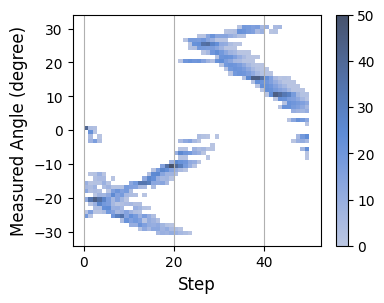

In [23]:
measured_angles_y_hist = []
measured_angles_x_hist = []

fig, ax_ang = plt.subplots(1, 1, figsize=(4, 3))
for i_suffix, _method_suffix in enumerate(['lowerleft', 'lowerright', 'center', 'upperleft', 'upperright']):

    # fig, ax_ang = plt.subplots(1, 1, figsize=(4, 3))
    measured_angles_demo = results_shifted_init[_method_suffix]['measured_angles']
    measured_angles_demo[measured_angles_demo > 180] -= 360
    measured_angles_x_hist += np.repeat(np.linspace(0,50,50)[None,:], 20, axis=0).reshape(-1).tolist()
    measured_angles_y_hist += measured_angles_demo.reshape(-1).tolist()

hist_plot_out = sns.histplot(x=measured_angles_x_hist, y=measured_angles_y_hist, bins=50, ax=ax_ang, color=f'C0', cbar=True)
# ax_ang.hist2d(measured_angles_x_hist, measured_angles_y_hist, bins=50, cmap='Blues')
ax_ang.set_xlabel('Step')
ax_ang.set_ylabel('Measured Angle (degree)')

ax_ang.xaxis.grid(True, which='both')

fig.savefig('figures/exp_benchmark_angle_hist.pdf', bbox_inches='tight')

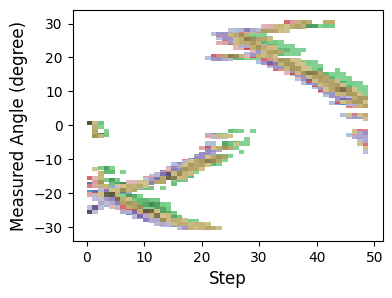

In [23]:

fig, ax_ang = plt.subplots(1, 1, figsize=(4, 3))
for i_suffix, _method_suffix in enumerate(['lowerleft', 'lowerright', 'center', 'upperleft', 'upperright']):

    # fig, ax_ang = plt.subplots(1, 1, figsize=(4, 3))
    measured_angles_demo = results_shifted_init[_method_suffix]['measured_angles']
    measured_angles_demo[measured_angles_demo > 180] -= 360

    sns.histplot(x=np.repeat(np.arange(50)[None,:], 20, axis=0).reshape(-1), y=measured_angles_demo.reshape(-1), bins=50, ax=ax_ang, color=f'C{i_suffix}')
    ax_ang.set_xlabel('Step')
    ax_ang.set_ylabel('Measured Angle (degree)')

(-5.0, 5.0)

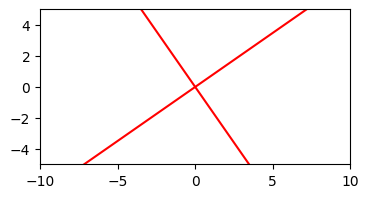

In [24]:


perpendicular_slope = -1 / fit_col[0]


fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(np.linspace(-20, 20, 101), fit_col[0] * np.linspace(-20, 20, 101) + fit_col[1], color='red')
ax.plot(np.linspace(-20, 20, 101), perpendicular_slope * np.linspace(-20, 20, 101), color='red')
ax.set_aspect('equal')

ax.set_xlim([-10, 10])
ax.set_ylim([-5,5])

In [25]:
dJ_samp = np.linspace(-3, 3, 4)

params_main_slope = np.hstack([dJ_samp[:,None], fit_col[0] * dJ_samp[:,None] + fit_col[1]]) + np.array([29, 1.68])
params_perp_slope = np.hstack([dJ_samp[:,None], perpendicular_slope * dJ_samp[:,None]]) + np.array([29, 1.68])

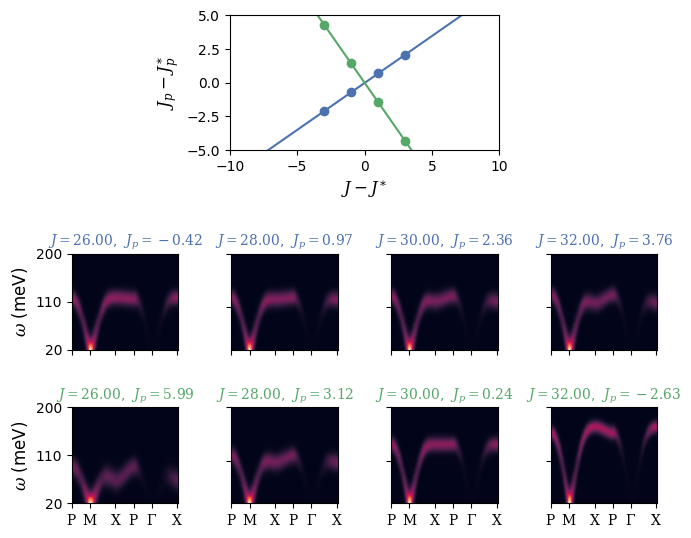

In [28]:

params_list = []
S_pred_list = []


mean_preds_demo = results_shifted_init['lowerright']['mean_preds']

for params in np.vstack([params_main_slope,params_perp_slope]):
    params = torch.from_numpy(params).to(device)
    # print(params)
    x = torch.zeros(wpts.shape[0], kpts.shape[0], 5)
    x[...,:3] = torch.cat([
        kpts.unsqueeze(0).expand(wpts.shape[0], -1, -1),
        wpts.view(wpts.shape[0], -1).unsqueeze(1).expand(-1, kpts.shape[0], -1)
    ], dim=2)
    x[...,3:] = params

    S_pred = model(x.to(model.device)).reshape(wpts.shape[0], kpts.shape[0]).detach().cpu().numpy()
    
    params_list.append(params)
    S_pred_list.append(S_pred)
    
w_idx_upper = 90
aspect = 0.5
extent = [0, S_pred_list[0].shape[1], 
          steer.experiment.w_grid.min().item(), steer.experiment.w_grid[w_idx_upper].item()]

fig = plt.figure(figsize=(7,6))

gs = fig.add_gridspec(2, 4, height_ratios=[1,1])

ax = fig.add_subplot(gs[0, 1:3])
ax.plot(np.linspace(-20, 20, 101), fit_col[0] * np.linspace(-20, 20, 101) + fit_col[1], color='C0')
ax.plot(np.linspace(-20, 20, 101), perpendicular_slope * np.linspace(-20, 20, 101), color='C1')
ax.plot(params_main_slope[:,0]-29, params_main_slope[:,1]-1.68 - fit_col[1], 'o', color='C0')
ax.plot(params_perp_slope[:,0]-29, params_perp_slope[:,1]-1.68, 'o', color='C1')
ax.set_aspect('equal')

ax.set_xlim([-10, 10])
ax.set_ylim([-5,5])
ax.set_xlabel(r'$J-J^{\ast}$')
ax.set_ylabel(r'$J_{p}-J_{p}^{\ast}$')

sub_gs = gs[1,:].subgridspec(2, 4, wspace=0.075, hspace=0.6)

for i in range(params_main_slope.shape[0]*2):
    ax = fig.add_subplot(sub_gs[i//4, i%4])
    ax.imshow(S_pred_list[i][:w_idx_upper,:], origin='lower', cmap=cmap, extent=extent, aspect=aspect)
    ax.set_title(f'$J={params_list[i][0]:.2f}$,  $J_{{p}}={params_list[i][1]:.2f}$',
                    fontsize=10, color='C0' if i < 4 else 'C1')
    
    if i == 0 or i == 4:
        ax.set_ylabel('$\omega$ (meV)')
        ax.set_yticks(np.linspace(20, 200, 3))
    else:
        ax.set_yticklabels([])
        
    if i >= 4:
        ax.set_xticks(kpt_indices)
        ax.set_xticklabels(kpt_labels)
    else:
        ax.set_xticks(kpt_indices)
        ax.set_xticklabels([])
    
fig.tight_layout()
fig.savefig('figures/sqw_slope_demos.pdf', bbox_inches='tight')